In [7]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import os
from tqdm import tqdm

In [8]:
df0 = pd.read_csv(f"./bt_stock_data/AAL.csv", index_col=0)
bad_tickers = []
for file in tqdm(os.listdir("./bt_stock_data/")):
       df = pd.read_csv(f"./bt_stock_data/{file}", index_col=0)
       if len(df.index) != len(df0.index):
              bad_tickers.append(file[:-4])

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 91.63it/s]


In [9]:
df_list = []

spy_ohlc_df = yf.download('SPY', start='2018-01-01', end='2021-12-31')

for file in tqdm(os.listdir("./bt_stock_data/")):
    
    #Load data
    ticker = file[:-4]
    df_feed = pd.read_csv(f".\\bt_stock_data\{ticker}.csv", index_col=0, parse_dates=True)
    
    #Create signal
    df_feed['nTransactions_signed'] = np.sign(df_feed['transactionShares']) * df_feed['numTransactions']
    df_feed['week_nTransactions_signed'] = df_feed['nTransactions_signed'].fillna(0).rolling(5).sum()
    df_feed['signal'] = np.where(df_feed['week_nTransactions_signed'] >= 3, 1, np.where(df_feed['week_nTransactions_signed'] <= -3,-1,0))
    
    #Add market data
    df_feed['spy_close'] = spy_ohlc_df['Adj Close']
    
    #Create a 90 day rolling covariance series
    rolling_cov = df_feed[['close','spy_close']].pct_change().rolling(90).cov().reset_index()
    rolling_cov = rolling_cov[rolling_cov['level_1'] == 'close'][['date','spy_close']].set_index('date')
    
    #beta = 90 day rolling covariance / 90 day rolling market variance
    beta_df = (rolling_cov / df_feed[['spy_close']].pct_change().rolling(90).var()).shift()
    
    period_array = [1, 5, 10, 20, 60, 120, 180, 250, 360, 500]
    for period in period_array:
        
        #Compute stock's performance over period long horizon and remove market component
        df_feed['FwdPerf' + str(period)] = df_feed['close'].pct_change(period).shift(-period) - \
            beta_df['spy_close'] * df_feed['spy_close'].pct_change(period).shift(-period)
    
    if df_feed.shape[0] > 0 and (df_feed.shape[0] == len(df_feed.index.unique())):
        if ticker in ['CRM', 'TECH', 'DLTR', 'V']:
            continue
        if ticker in bad_tickers:
            continue  
            
        df_list.append(df_feed[['signal'] + ['FwdPerf' + str(period) for period in period_array]])
        
complete_df = pd.concat(df_list)

[*********************100%***********************]  1 of 1 completed


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  7.99it/s]


In [10]:
bias_array = []

#Compute bias (correlation * sigma_y) for each forward performance period
for period in period_array:
    subset = complete_df[['signal','FwdPerf'+str(period)]].dropna()
    bias_array.append(sm.OLS(subset['signal'],sm.add_constant(subset['FwdPerf' + str(period)])).fit().params['FwdPerf' + str(period)] * subset['signal'].std())

Text(0, 0.5, 'Bias')

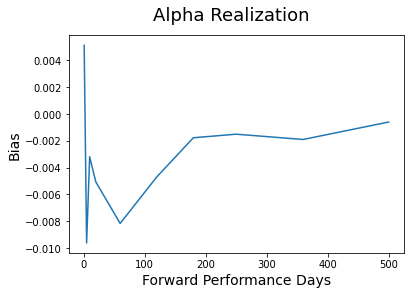

In [11]:
fig = plt.figure()
plt.plot(period_array, bias_array)
fig.suptitle('Alpha Realization', fontsize=18)
plt.xlabel('Forward Performance Days', fontsize=14)
plt.ylabel('Bias', fontsize=14)